# Spotify Models

We used various models to explore the best way to identify the similarity between the tracks and predict similar songs, to be able to generate a final recommendation playlist. In modelling we included a sample dataset of 10,000 playlists from the 1 million playlists dataset. We split the sample dataset into a Playlist Bank and a Training set. The Playlist Bank contains 90% of the data (9,000) playlists and the Training Set contains 10% of the data (1,000) playlists. 

In this script, we include:

1. Baseline model: we adopt 'Jaccard similarity' to calculate similarity score of each pair of playlist in our dataset, and predict the tracks in similar playlists.


2. Advanced models
 - Linear regression / Linear regression with encoded variables
 - Lasso
 - Gradient Boosted Trees
 - Artificial neural network: we use latent vector to create a collaborative filtering neural network and use the model to predict the "interaction" score for user(playlist) and item(track), we include the parameter selection process and the final model fitting
 

3. Combined model: combine baseline and advanced model together to generate the final recommendation list.

In [1]:
#import related packages
import warnings
warnings.filterwarnings('ignore')

import json
import pandas as pd
import numpy as np
import scipy.sparse as sp
import keras
from keras import backend as K
from keras.models import Sequential, Model, load_model, save_model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, merge, Reshape, Flatten, add
from keras.optimizers import Adam
from keras.regularizers import l2
from time import time
import multiprocessing as mp
import sys
import math
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.linear_model import Lasso
from collections import OrderedDict
from operator import itemgetter
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression

!pip install xgboost
import xgboost as xgb

Using TensorFlow backend.


/bin/sh: 1: pip: not found


# Dataset Preparation

In [2]:
#count script running times
start = timer()

In [3]:
#function: combine separate dataset and get the 
#playlists(a dictionary with key of playlist id and value of a list of tracks)

#input: n is how many piece of data that will be generated(1 piece of data has 1,000 playlists)
#       m is the starting point(eg. the 1th piece of data)
#output: a dictionary containing users(playlists id) and track names

def load_dataset(n, m):
    c = m*1000
    playlists = {}
    pieces = []
    for p in range(m, n+m):
        start = p*1000
        end = start+999
        with open('data/mpd.slice.{0}-{1}.json'.format(start, end)) as f:
            piece = json.load(f)
            play_list = [lst['tracks'] for lst in piece['playlists']]
            for ply in play_list:
                track_names = [track_name['track_name'] for track_name in ply]
                playlists[c] = track_names
                c += 1
            pieces.append(piece)
    return playlists, pieces

In [4]:
#function: get the dataframe(index, user, track, interaction{1=interaction exists})
#input: a dictionary of playlist
#output: the cleaned dataframe

def get_data(playlists):
    users, items = [], []
    for user in playlists:
        for item in playlists[user]:
            users.append(user)
            items.append(item)
            
    data = pd.DataFrame(users, columns=['user'])
    data['track'] = items
    
    #encoding the track names into numbers
    data['track'] = data['track'].astype('category').cat.codes
    
    return data 

There will be two dataset to work on:
- the first is the full dataset including 10,000 playlists(the first 10 pieces of the whole dataset), it will be used for model training and tesing.
- the second dataset is the dataset used for model parameter optimization (cross validation to select best parameter)

The final dataset will be finally like:
![baseline model](image/data_example.jpg)

where "user" is defined as each individual playlist. The "track" is randomly selected tracks in the full dataset, noted that each track is encoded into numbers. The "y" is the interaction of the user and item(playlist). If the track exists in the playlist, the "y" (interaction) will be 1, otherwise it will be 0.

In [5]:
#Define the size of data
n_playlist = 10
m_playlist = 0
n_adjust = 1
m_adjust = 10

In [6]:
#Get the two dataset
data_features, complete_data = load_dataset(n_playlist, m_playlist)
data_features_adjusted = load_dataset(n_adjust, m_adjust)[0]
data_full = get_data(data_features)
data_adjust = get_data(data_features_adjusted)
data_adjust.user = data_adjust.user-m_adjust*1000

# Baseline Model

**Model Description**

The baseline model is based on comparing each pair of “tracks” and hence computing the “similarity score” by using the 'Jaccard similarity' similarity measurement:
![jaccard similarity](image/jaccard_similarity.jpg)

The dataset we use in baseline model is the full dataset(10,000) playlist.

The baseline model assumes that one user owns at least one playlist, and it computes the similarity score
of this user playlist with each of the playlists in the dataset. The recommendation tracks will be generated from
the playlist that has the highest similarity with the user playlist.

In this model, we only include a sample dataset of 10,000 playlists from the whole dataset (1 million
playlists). We split the sample dataset into a Playlist Bank and a Training set. The Playlist Bank contains
90% of the data (9,000) playlists and the Training Set contains 10% of the data(1,000) playlists. For each playlist in the Training Set, we hide one track to be the track that we try to predict, and we set the rest as our predictors. For each training list, if the hidden track exist in our prediction track list, we will define the error rate of this training list to 0, otherwise, to 1. And we average the total error of 500 playlists to be our total error rate.

For the final recommendation tracks, we will first get the not-overlap tracks in top 5 similary playlists, and randomly select 100 as our recommendation.

**Model design**

![baseline model](image/baseline_model.jpg)

In [7]:
#split the data into playlist bank (90%) and training set (10%)
playlist_bank = {}
for user in range(n_playlist*900):
    playlist_bank[user] = list(data_full[data_full['user']==user]['track'])

playlist_data = {}
for user in range(n_playlist*900, n_playlist*1000):
    playlist_data[user] = list(data_full[data_full['user']==user]['track'])

In [8]:
#check out the length of playlist bank and the training set
print(len(playlist_bank))
print(len(playlist_data))

9000
1000


In [9]:
#define the similarity function
#input: two list with items
#output: the similairty score of two lists
def cal_similarity(list_one, list_two):
    no_overlap = list(Counter(list_one)-Counter(list_two))
    similarity = ((len(list_one)-len(no_overlap))*2)/(len(list_one)+len(list_two))
    return similarity

In [10]:
# Create the function to hide the first track in each playlist
#input: the dictionary of playlists
#output: a list of the hidden track and a dictionary of users and the unhidden tracks
def hide_track(playlists):
    track_hide = []
    track_train = {}
    for key in playlists:
        track_hide.append(playlists[key][0])
        track_train[key] = playlists[key][1:]
    return track_hide, track_train

In [11]:
# Create the function of getting the recommendation list
#input: the playlists that is to be predicted
#       the playlist bank
#       the number of similar playlist that need to be generated
#output: the list of recommendation tracks

def get_recommendation_list(track_train, playlist_bank, no_similar_playlist):
    recommendation_track = []
    time_train = 0
    for ut in track_train:
        sim_score = np.zeros(len(playlist_bank))
        time_bank = 0
        for ub in playlist_bank:
            sim_score[time_bank] = cal_similarity(track_train[ut], playlist_bank[ub])
            time_bank += 1
        similarity_df = pd.DataFrame(sim_score, index=range(len(sim_score)))
        similarity_df = similarity_df.sort_values(by=0, ascending=False)
        index = list(similarity_df.index[[x for x in range(no_similar_playlist)]])
        sample_names = []
        for i in index:
            sample_names.append(playlist_bank[i])
        recommendation_track.append([track for playlist in sample_names for track in playlist])
        time_train += 1
    return recommendation_track    

In [12]:
#Get the list of hidden track and the dictionary of training tracks
track_hide, track_train_base = hide_track(playlist_data)

In [13]:
#Get the top 5 similar playlists as our base of recommendation list
#Randomly select 100 of them as our final recommendation
recommendation_list = get_recommendation_list(track_train_base, playlist_bank, 5)
no_recommendation = 100

In [14]:
#Calculate the score of the prediction
scores = np.zeros(len(track_train_base))
for n in range(len(track_hide)):
    not_overlap = list(Counter(recommendation_list[n])-Counter(track_train_base[n+900*m_adjust]))
    np.random.shuffle(not_overlap)
    recommendation = np.array(not_overlap)[:no_recommendation]
    if track_hide[n] in recommendation:
        scores[n] = 1
score = np.mean(scores)    

In [15]:
print('The score is {0}'.format(score))

The score is 0.166


We can see that the score is very low of this baseline model because it has several limiations:

1. Bias in calculating similarity score: although the process of finding the hidden track is supervised, the process of calculating similarity score is actually unsupervised since we don’t have an exact benchmark for “similarity of two playlists”. Therefore, the similarity score we calculated may be hesitated.

2. Even though we find the top 5 similar playlists, we applied no but the random selection techque in choosing the 100 tracks as our recommendation. Other critera will be explored in advanced models.

3. Too much related to the sample size: the sample is small, and it only contains 1% of the original dataset. The bigger the Playlist Bank, the higher the probability we find a “twin” of our training list.

4. Predictor selection: the only predictor we use to compute the similarity is “track_name” in the playlist. However, there are more predictors in the dataset that seem to be useful, such as “album_name”, “artist_name”, “popular_artist”, “popular_album”, “playlist_name”, and so on. They will be exlored in the advanced modeling.

5. Computation cost: the computation cost need to be reduced.

7. Cold-start problem: since the model assumes that there is already an existing playlist for one user, it does not take the “cold-start” problem into account. This issue should be discussed in the advanced model.

# Improving the Models

We implemented additional data processing to be able to identify the most popular songs. An array of dictionaries was created utilized in identifying top songs from playlists.

In [16]:
print(complete_data[0].keys())
print(complete_data[0]['info'])

# # Alloc all playlists as array of dictionaries
all_playlists = []
for i,j in enumerate(complete_data):
    for k,l in enumerate(j['playlists']):
        all_playlists.append(l) 
print("Total number of playlists: ", len(all_playlists))
unclean_df = pd.DataFrame(all_playlists)
unclean_df.head()

dict_keys(['info', 'playlists'])
{'generated_on': '2017-12-03 08:41:42.057563', 'version': 'v1', 'slice': '0-999'}
Total number of playlists:  10000


,collaborative,description,duration_ms_mean,name,num_albums,num_artists,num_edits,num_followers,num_tracks,popular_album,popular_artist,tracks
0,false,NaN,221777,Throwbacks,47,37,6,1,52,Departure - Recharged,Jesse McCartney,"[{'album_name': 'The Cookbook', 'duration_ms':..."
1,false,NaN,298883,Awesome Playlist,23,21,5,1,39,Moving Pictures,Rush,"[{'album_name': 'Eye Of The Tiger', 'duration_..."
2,false,NaN,219374,korean,51,31,18,1,64,Everything You Wanted,BTS,"[{'album_name': 'On And On', 'duration_ms': 21..."
3,false,NaN,229571,mat,107,86,4,1,126,Live A Little Love A Lot,Hüsker Dü,"[{'album_name': 'French Festival', 'duration_m..."
4,false,NaN,255016,90s,16,16,7,2,17,Mellon Collie and the Infinite Sadness,The Smashing Pumpkins,[{'album_name': 'Mellon Collie and the Infinit...


In [17]:
## Count all top songs in tracks array
unclean_copy = unclean_df.copy()
def get_popular(items):
    return str(max(set(items), key=items.count))

t_song = []
t_dict = {}

for element in unclean_copy['tracks']:
    top_song_artist = []
    
    for track in element:
        key = track['track_name']
    
        if key in t_dict:
            t_dict[key] += 1
        else:
            t_dict[key] = 1


Linear regression is the first step in the improvement we made to our modelling. The response variable chosen is `num_followers`, as the songs in a playlist with a high number of followers are most likely to be popular or become popular in the future.  

In [18]:
ordered_songs = OrderedDict(sorted(t_dict.items(), key=itemgetter(1), reverse=True))
print("We are observing over {} different songs".format(len(ordered_songs)))

We are observing over 132920 different songs


In [19]:
clean_df = unclean_copy.drop(['description', 'tracks'], axis=1 )
clean_df.describe()

,duration_ms_mean,num_albums,num_artists,num_edits,num_followers,num_tracks
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,2.345734e+05,49.684000,38.246900,17.926500,3.50220,66.471200
std,4.031545e+04,39.722617,30.246617,20.809195,161.03533,53.487764
min,7.864500e+04,2.000000,3.000000,2.000000,1.00000,5.000000
25%,2.187135e+05,20.000000,16.000000,5.000000,1.00000,26.000000
50%,2.302930e+05,37.000000,30.000000,10.000000,1.00000,50.000000
75%,2.449848e+05,68.000000,52.000000,23.000000,1.00000,91.000000
max,2.846491e+06,233.000000,199.000000,178.000000,15842.00000,250.000000


We decided to view the duration in minutes rather than the given milliseconds

In [20]:
# Get a column of duration_min_mean based on millisecond column
dur_ms_mean = clean_df[['duration_ms_mean']]

min_arr = []
for k,v in dur_ms_mean.items():
    min_arr.append(v/60000)
    
# Append new Minute data column
tz = np.asarray(min_arr)
clean_df['duration_min_mean'] = tz[0]

clean_df.describe()
# clean_df.head()

,duration_ms_mean,num_albums,num_artists,num_edits,num_followers,num_tracks,duration_min_mean
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,2.345734e+05,49.684000,38.246900,17.926500,3.50220,66.471200,3.909556
std,4.031545e+04,39.722617,30.246617,20.809195,161.03533,53.487764,0.671924
min,7.864500e+04,2.000000,3.000000,2.000000,1.00000,5.000000,1.310750
25%,2.187135e+05,20.000000,16.000000,5.000000,1.00000,26.000000,3.645225
50%,2.302930e+05,37.000000,30.000000,10.000000,1.00000,50.000000,3.838217
75%,2.449848e+05,68.000000,52.000000,23.000000,1.00000,91.000000,4.083079
max,2.846491e+06,233.000000,199.000000,178.000000,15842.00000,250.000000,47.441517


In [21]:
clean_df.describe()

,duration_ms_mean,num_albums,num_artists,num_edits,num_followers,num_tracks,duration_min_mean
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,2.345734e+05,49.684000,38.246900,17.926500,3.50220,66.471200,3.909556
std,4.031545e+04,39.722617,30.246617,20.809195,161.03533,53.487764,0.671924
min,7.864500e+04,2.000000,3.000000,2.000000,1.00000,5.000000,1.310750
25%,2.187135e+05,20.000000,16.000000,5.000000,1.00000,26.000000,3.645225
50%,2.302930e+05,37.000000,30.000000,10.000000,1.00000,50.000000,3.838217
75%,2.449848e+05,68.000000,52.000000,23.000000,1.00000,91.000000,4.083079
max,2.846491e+06,233.000000,199.000000,178.000000,15842.00000,250.000000,47.441517


- Majority of playlist songs don't go beyond 47 minutes (based on our minute max) with the average song being 3.9 minutes long. 
- Given that the average playlist number is 66.
- 3.9 * 66.4 = 258.96 minutes per playlist
- Number of minutes in sample dataset 2,589,600 (average)
    - 258.96 * 66.47 = 2,589,600 

We then wanted to change the true and false categorical variables to a binary equivalent, where 0=false and 1=true

In [22]:
# Convert categorical false and true to their integer equivalent. 
# false = 0
# true = 1
d = {'false': 0, 'true': 1}
tmp = clean_df['collaborative'].map(d)
tmp.head()

0    0
1    0
2    0
3    0
4    0
Name: collaborative, dtype: int64

In [28]:
clean_df['collaborative'] = tmp.values
clean_df.head()

# Copy prev dataframe
clean_df_2 = clean_df.copy()

### Methods for Initial Data Exploration: 

We first wanted to see if there was a disparity between popular playlists being created by 1 person/company, as opposed to having many collaborators contributing to the popularity of the playlist.

In [29]:
# Get predictors for num_followers
y_num_followers = clean_df_2[['num_followers']]

x_wo_followers = clean_df_2.drop('num_followers', axis=1)

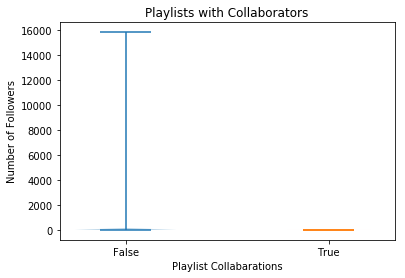

In [30]:
# Check if playlists with collabators have a huge following

plt.violinplot(clean_df_2.loc[clean_df_2.collaborative==0,'num_followers'],positions=[1])
plt.violinplot(clean_df_2.loc[clean_df_2.collaborative==1,'num_followers'],positions=[2])

plt.xlabel("Playlist Collabarations")
plt.xticks([1,2], ["False","True"])
plt.ylabel("Number of Followers")
plt.title('Playlists with Collaborators')
plt.show()

As we can tell that playlists with a huge following are actually made by either 1 person or an organization, the popular playlists don't take contributors. 

We also wanted to check if there were any popular playlists with just 1 artist (like playlists dedicated to a specific artist) this could help us notice if popular artists can have a strong enough following to not need other artists music to increase their following.

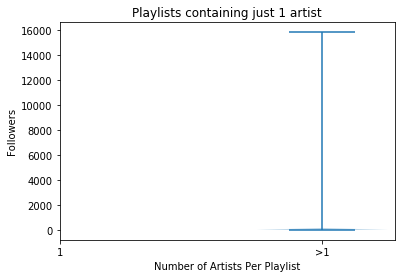

In [31]:
try:
    plt.violinplot(clean_df_2.loc[clean_df_2.num_artists==1,'num_followers'],positions=[1])
except ValueError:  #raised if `x` is empty.
    pass

plt.violinplot(clean_df_2.loc[clean_df_2.num_artists > 1,'num_followers'],positions=[2])

plt.xlabel("Number of Artists Per Playlist")
plt.title("Playlists containing just 1 artist")
plt.xticks([1,2], ["1",">1"])
plt.ylabel("Followers")
plt.show()

We can notice that even popular artists don't have enough of a strong following to pull in a large amount of followers or that not many people create a playlist based solely on one artist.

Now that we have curated our data to be more manageable, we decided to take a look at possible similarities with the data we currently have.

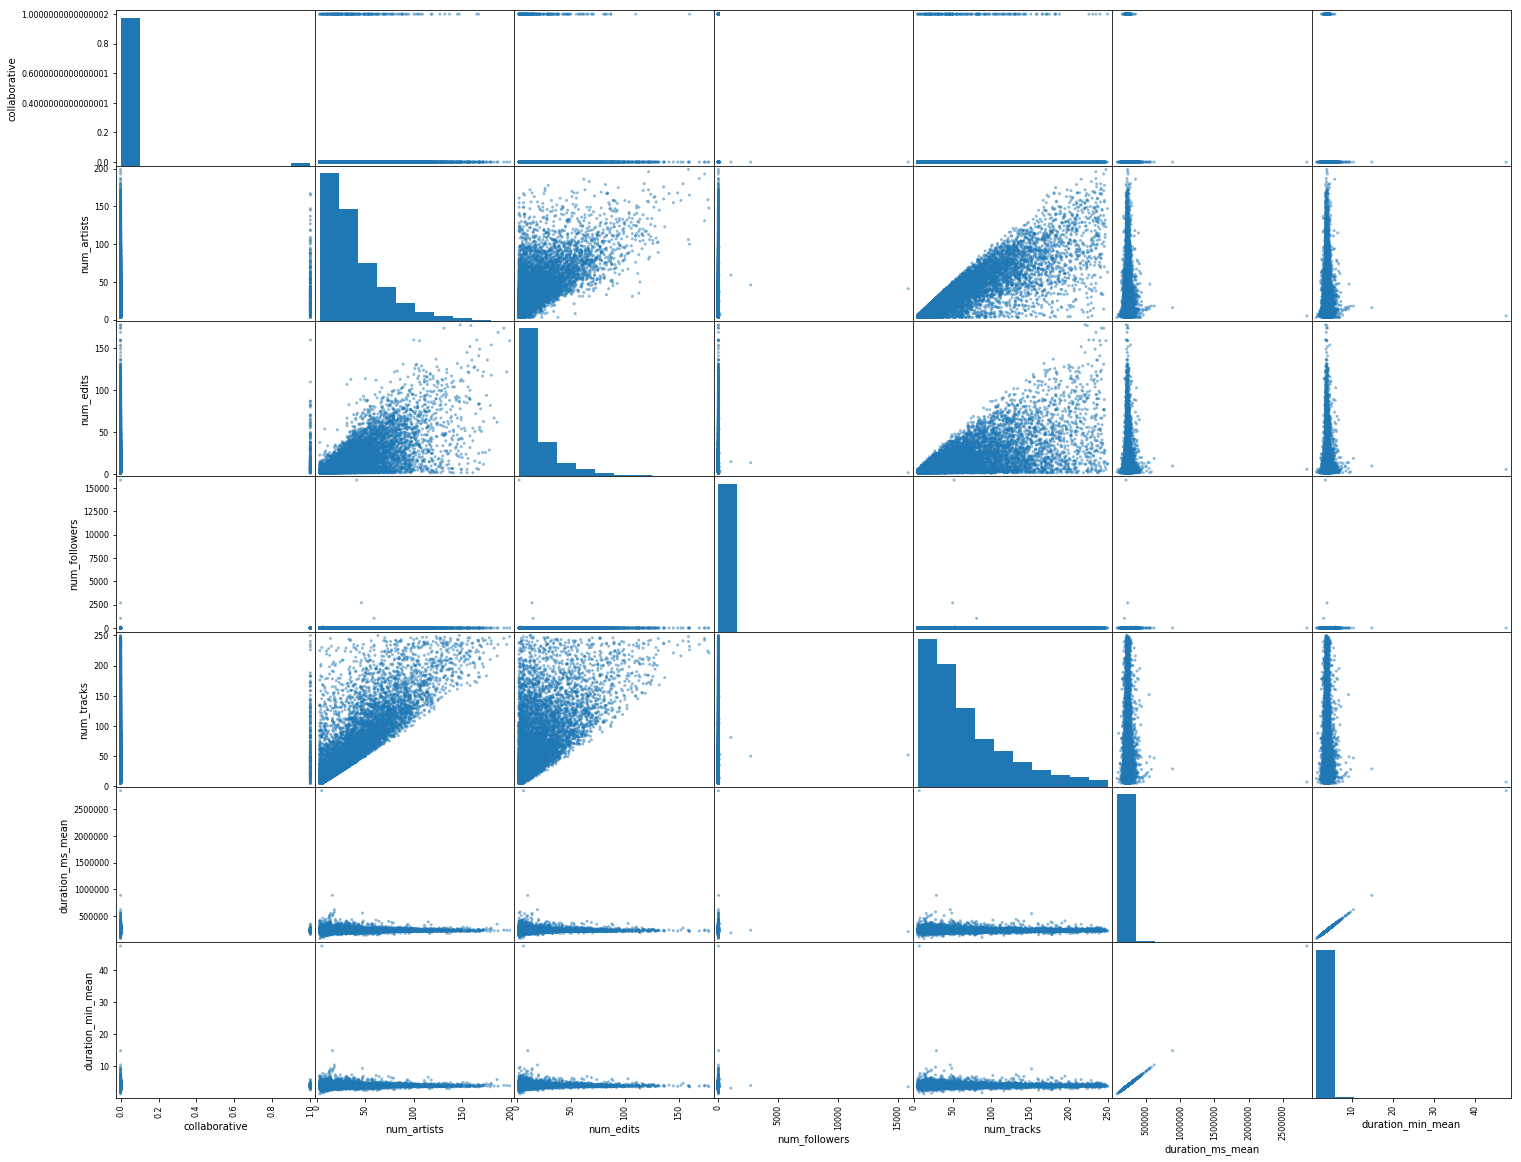

In [32]:
# Check features
cols_wanted = [
    'collaborative',
    'name',
    'num_artists', 
    'num_edits', 
    'num_followers', 
    'num_tracks', 
    'duration_ms_mean', 
    'duration_min_mean',
    'popular_artist' # doesnt account for categorical variable so this actually never gets displayed
]

scatter_matrix(clean_df_2[cols_wanted], alpha=0.5, figsize=(25,20));

We decided to take a look at the most popular artists and see how much of the dataset it actually takes up.

In [33]:
# most popular artists among the playlists
pop_art = clean_df_2['popular_artist'].value_counts()
print("Unique Artists in Sample: ",len(pop_art))

art_sample_5 = pop_art[:5]
print("Top 5 artists in Sample make up: {} of the sample dataset. \nThe top 5 artists are: \n{} ".format(sum(art_sample_5),pop_art[:5]) )

print("")
print("Out of: {} playlists".format(sum(clean_df_2['popular_artist'].value_counts())) )

print("Top 5 artists make up: {}% of dataset ".format(sum(art_sample_5)/sum(clean_df_2['popular_artist'].value_counts()) * 100))

Unique Artists in Sample:  2874
Top 5 artists in Sample make up: 786 of the sample dataset. 
The top 5 artists are: 
Drake               361
The Chainsmokers    128
Beyoncé             101
Rihanna             100
Ed Sheeran           96
Name: popular_artist, dtype: int64 

Out of: 10000 playlists
Top 5 artists make up: 7.86% of dataset 


Top X artists exist in :
786 rows


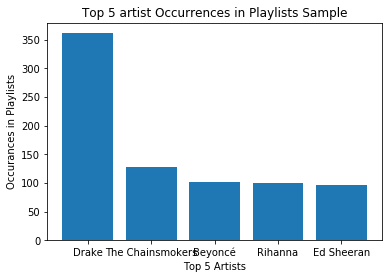

In [34]:
art_sample_5.keys
art_sample_5.values

print("Top X artists exist in :")
print(len(clean_df_2[clean_df_2['popular_artist'].isin(art_sample_5.keys())]), "rows")
plt.title("Top 5 artist Occurrences in Playlists Sample")
plt.ylabel("Occurances in Playlists")
plt.xlabel("Top 5 Artists")

plt.bar(art_sample_5.keys(), art_sample_5.values)
plt.show()

In [35]:
# Safety First!!! Q_Q
untouched_df_clean = clean_df_2.copy()

Noticing that the popular artists make up a decent portion of our dataset we decided to explore possibilities, by isolating only the top 5 popular artists and see if we can notice some trends

In [36]:
# Dataframe with only popular X artists so we can compare categorical variables
pop_df = clean_df_2.loc[clean_df_2['popular_artist'].isin(art_sample_5.keys())]
pop_df.head()

,collaborative,duration_ms_mean,name,num_albums,num_artists,num_edits,num_followers,num_tracks,popular_album,popular_artist,duration_min_mean
34,0,226872,good good,72,65,39,1,80,The Chainsmokers- Japan Special Edition,The Chainsmokers,3.781200
35,0,217815,Good Vibes,58,52,56,1,70,Purpose,The Chainsmokers,3.630250
38,0,238427,tb,51,42,16,1,53,Good Girl Gone Bad,Rihanna,3.973783
40,0,219678,2020,80,71,27,6,85,BEYONCÉ [Platinum Edition],Beyoncé,3.661300
60,0,247444,Ski,64,64,30,2,66,ANTI,Rihanna,4.124067


In [37]:
# Turn the categorical artist names to numerical values so we can better compare against
unique_artists_pop = set(pop_df['popular_artist'].values)
print(unique_artists_pop)
art_int_cols = {}

counter = 0
for i in unique_artists_pop:
    art_int_cols[i] = counter
    counter+=1

print("Top 5 artists by key:",art_int_cols)

tmp3 = pop_df['popular_artist'].map(art_int_cols)
print(tmp3[:5])

pop_df['popular_artist'] = tmp3

print("Shape of our dataset: ",pop_df.shape)
pop_df.head()

{'Beyoncé', 'Rihanna', 'Ed Sheeran', 'The Chainsmokers', 'Drake'}
Top 5 artists by key: {'Beyoncé': 0, 'Ed Sheeran': 2, 'Rihanna': 1, 'The Chainsmokers': 3, 'Drake': 4}
34    3
35    3
38    1
40    0
60    1
Name: popular_artist, dtype: int64
Shape of our dataset:  (786, 11)


,collaborative,duration_ms_mean,name,num_albums,num_artists,num_edits,num_followers,num_tracks,popular_album,popular_artist,duration_min_mean
34,0,226872,good good,72,65,39,1,80,The Chainsmokers- Japan Special Edition,3,3.781200
35,0,217815,Good Vibes,58,52,56,1,70,Purpose,3,3.630250
38,0,238427,tb,51,42,16,1,53,Good Girl Gone Bad,1,3.973783
40,0,219678,2020,80,71,27,6,85,BEYONCÉ [Platinum Edition],0,3.661300
60,0,247444,Ski,64,64,30,2,66,ANTI,1,4.124067


In this example we can see that even though that there is top 5 artists, the top 5 artists have up to 503 top songs. Perhaps if we separate by top songs rather than artists we can see some trends

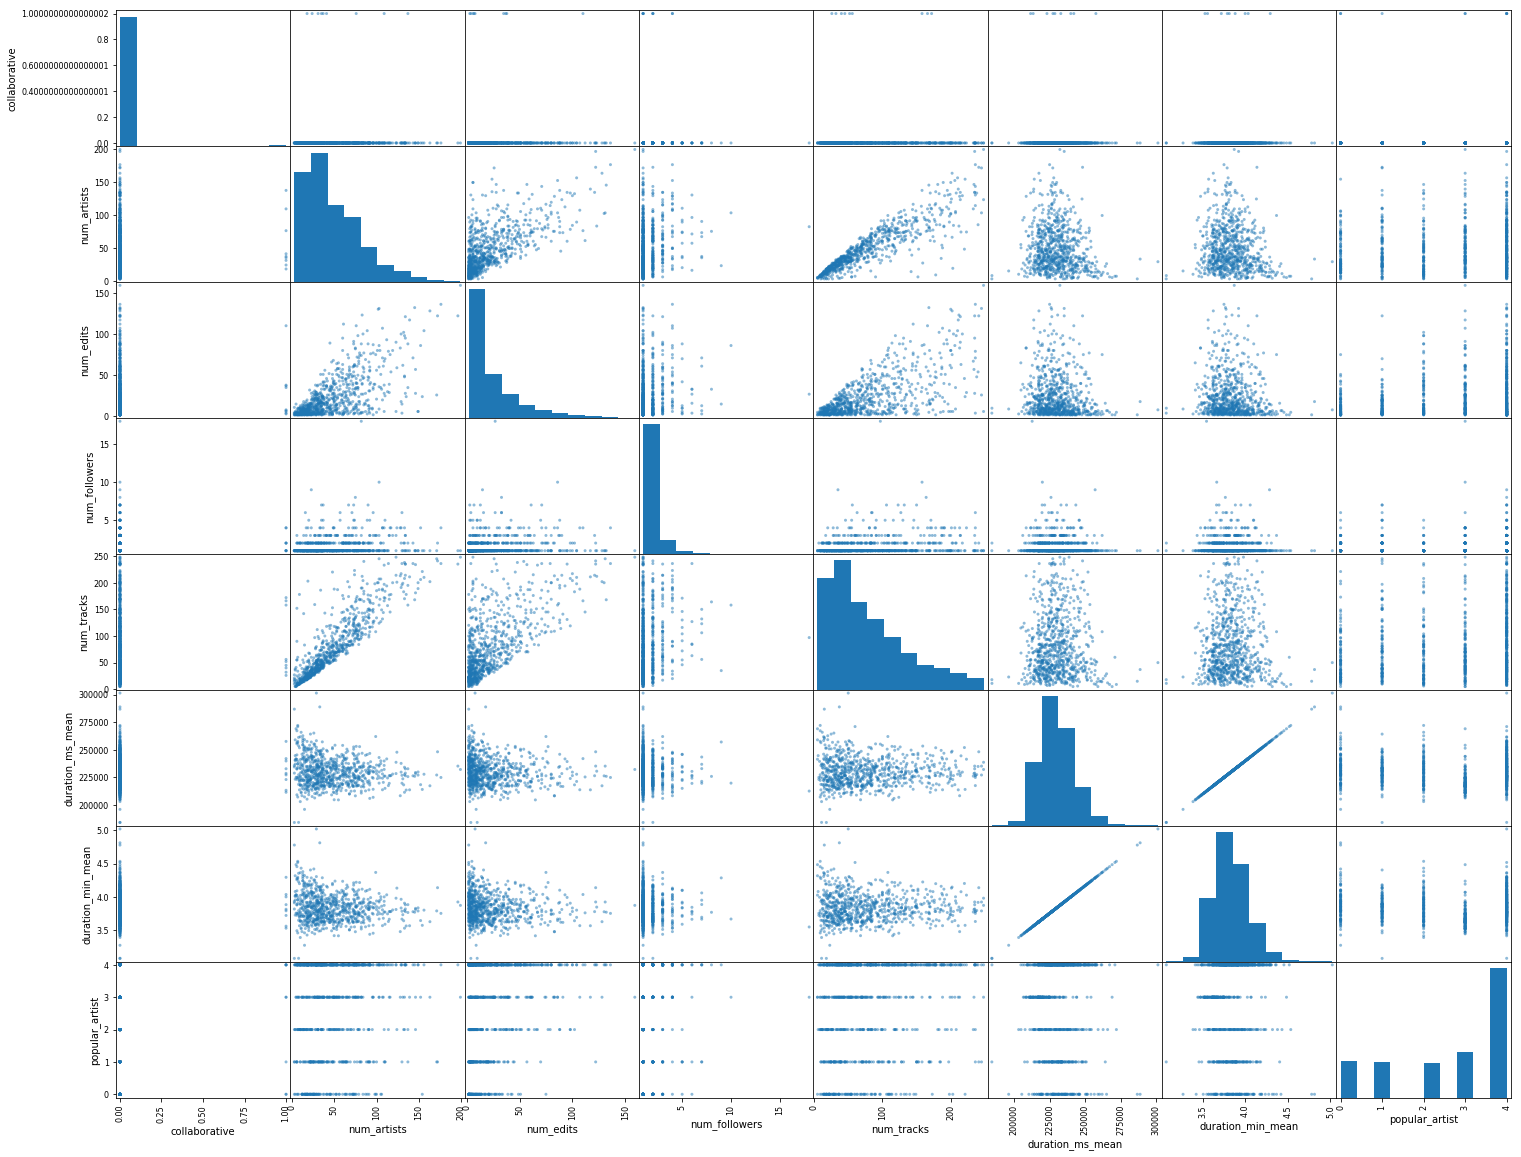

In [38]:
# Run a scatter matrix on the top 5 artist Dataframe to see any interesting occurences 
cols_wanted2 = [
    'collaborative',
    'name',
    'num_artists', 
    'num_edits', 
    'num_followers', 
    'num_tracks', 
    'duration_ms_mean', 
    'duration_min_mean',
    'popular_artist'
]

scatter_matrix(pop_df[cols_wanted2], alpha=0.5, figsize=(25,20));

Since there is not anything necessarily out of the ordinary in the scatter matrix above as the spread is too large, we begin to go back to the drawing board and look at classifying our data given the predictors we have. 

In [39]:
print(untouched_df_clean.shape)
untouched_df_clean.head()

(10000, 11)


,collaborative,duration_ms_mean,name,num_albums,num_artists,num_edits,num_followers,num_tracks,popular_album,popular_artist,duration_min_mean
0,0,221777,Throwbacks,47,37,6,1,52,Departure - Recharged,Jesse McCartney,3.696283
1,0,298883,Awesome Playlist,23,21,5,1,39,Moving Pictures,Rush,4.981383
2,0,219374,korean,51,31,18,1,64,Everything You Wanted,BTS,3.656233
3,0,229571,mat,107,86,4,1,126,Live A Little Love A Lot,Hüsker Dü,3.826183
4,0,255016,90s,16,16,7,2,17,Mellon Collie and the Infinite Sadness,The Smashing Pumpkins,4.250267


We first decided to use `num_followers` as our response variable with our predictors only being numerical variables and removing the other cateogorical variables 

### Linear Regression

Linear regression is the first step in the improvement we made to our baseline model. The response variable chosen is num_followers, as the songs in a playlist with a high number of followers are most likely to be popular or become popular in the future. The predictors used were only the numerical variables and removing the other categorical variables.  So the predictors included were (collaborative, duration, num_albums, num_artists, num_edits, num_tracks, duration_min).

The score for this model is -0.0038.

 The first issue we identified with this model were the outliers. The top playlists are called ‘Now Playing’ and ‘Top Pop’ which is one of Spotify and Interscope generated playlists. Most likely, these songs are predefined to already be popular, or up and coming. However, we decide to keep these playlists in the dataset due the large number of followers that they have and their impact in the model performance and our dependent variable (num_followers).


In [40]:
# Clean up categorical variables 
clean_categorical_df = untouched_df_clean.drop(['name', 'popular_album', 'popular_artist'], axis=1 )

# Split into test datasets
X_train, X_test, y_train, y_test = train_test_split(clean_categorical_df.drop('num_followers', axis=1),clean_categorical_df['num_followers'], test_size=0.33, random_state=42 )

# Fit a Multilinear Regression Model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [41]:
linreg.score(X_test, y_test)

-0.0038291298743347024

We noticed looking at the coefficients that there are some outliers that may be skewing our results. We decided to dive deeper.

In [42]:
#We can see the 3rd columns negative coefficients is far different than the rest which seem pretty calm
linreg.coef_

array([-2.48097443e+00, -4.85389761e-05, -2.75847547e-02,  1.47803917e-01,
       -1.44966348e-01, -2.22800770e-02, -8.08982975e-10])

In [43]:
# We check the first 10 items in our predictions against what it should result to in the y_test
print("Predictions (first 10):", linreg.predict(X_test)[:10])
print("")
print("True values (first 10):\n{}".format(y_test[:10]))

Predictions (first 10): [ 4.16747251  4.29853431  9.71456744  6.70981929  1.10323296  3.78311267
  6.11011493  5.04846683 -3.86752462  6.47423513]

True values (first 10):
6252    1
4684    1
1731    1
4742    2
4521    1
6340    1
576     1
5202    1
6363    1
439     2
Name: num_followers, dtype: int64


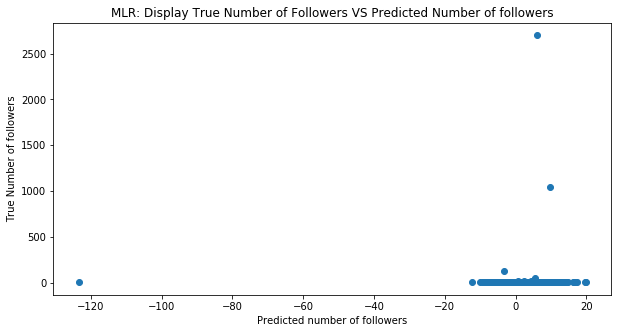

In [44]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

ax.scatter(linreg.predict(X_test), y_test)

ax.set_ylabel("True Number of followers")
ax.set_xlabel("Predicted number of followers")
ax.set_title("MLR: Display True Number of Followers VS Predicted Number of followers")
plt.show()

In [45]:
print("Display the outliers in our Test Set to see what may be ruining our model (Lowest to Highest):")
print(np.argsort(y_test)[::][:5])

Display the outliers in our Test Set to see what may be ruining our model (Lowest to Highest):
6252       0
4684    2038
1731    2040
4742    2043
4521    2044
Name: num_followers, dtype: int64


In [46]:
print("Display the outliers in our Test Set to see what may be ruining our model (Highest to Lowest):")
print(np.argsort(y_test)[::-1][:5])

Display the outliers in our Test Set to see what may be ruining our model (Highest to Lowest):
9401    2490
8781     117
6094    1253
9754      86
1744    1196
Name: num_followers, dtype: int64


We decided to see how the outliers in our Test Set differ from the other datapoints so we can better figure out if there is some variable we are not accounting for in the dataset.

In [47]:
# Create a new dataframe to better see how the outliers differ compared to the other predictors.
temp = X_test.copy()
temp['num_followers'] = y_test

temp.sort_values(['num_followers'], ascending=False, inplace=True)
temp.head()
# what makes these have so many followers?
# do we not have the data? 

,collaborative,duration_ms_mean,num_albums,num_artists,num_edits,num_tracks,duration_min_mean,num_followers
2957,0,235302,47,46,14,50,3.921700,2699
765,0,186569,37,59,15,81,3.109483,1038
4960,0,355743,10,6,4,53,5.929050,128
3305,0,214470,28,25,9,36,3.574500,53
1923,0,196855,64,51,13,196,3.280917,23


After fixing the dataframe and we can now better access what may be causing certain datapoints to be `outliers`. We can see that the top playlists are actually called `Now Playing` and `Top Pop`(generated by Interscope Records) which is one of Spotify's generated playlists and Interscopes Generated Playlist that changes daily so the songs in this playlist can mean 1 of 2 things. 
- These songs are predefined to already be popular, or up and coming
- These songs are by no means a representation of what people want to listen to since they change too frequently to access. 

This leaves the question if these playlists should even be left in the dataset since we may be picking up on prediction patterns that these playlists are using, which could alter our results negatively because we will have unnecessary noise, or that we should examine these playlists exclusively since we can mimic an Ensemble Method in which we assume each popular playlist has its own way to determine if a song should be in a playlist. 

In [48]:
# Create clean dataframes
df_newclean = untouched_df_clean.copy()

temp2 = df_newclean.copy()
temp2.sort_values(['num_followers'], ascending=False, inplace=True)
temp2.head()

,collaborative,duration_ms_mean,name,num_albums,num_artists,num_edits,num_followers,num_tracks,popular_album,popular_artist,duration_min_mean
7215,0,211648,TOP POP,46,41,2,15842,52,Evolve,Imagine Dragons,3.527467
2957,0,235302,Now Playing,47,46,14,2699,50,Wild and Reckless,Courtney Barnett,3.921700
765,0,186569,Tangled,37,59,15,1038,81,Moana,Mandy Moore,3.109483
4960,0,355743,meditation,10,6,4,128,53,Awakening the Fire,Marina Raye,5.929050
1750,0,281318,No Limit,12,8,2,87,14,Unpredictable,Tru$,4.688633


We decided to keep the generated playlists in our sample dataset since it should only help improve model performance

In [50]:
# hot encode popular artist categorical variable
df_newclean = untouched_df_clean.copy()
dummy_art = pd.get_dummies(df_newclean['popular_artist'])
print("Shape of hot encoded Categorical variable Popular Artist",dummy_art.shape)

# merge
df_newclean.shape
merge_df = pd.concat([df_newclean, dummy_art], axis=1)
merge_df.head()

Shape of hot encoded Categorical variable Popular Artist (10000, 2874)


,collaborative,duration_ms_mean,name,num_albums,num_artists,num_edits,num_followers,num_tracks,popular_album,popular_artist,...,xxyyxx,Édith Piaf,Ó,Ólafur Arnalds,Джиган,Николай Басков,Русавуки,Юлия Савичева,松司馬拓指揮 Ensemble FOVE,鄭源
0,0,221777,Throwbacks,47,37,6,1,52,Departure - Recharged,Jesse McCartney,...,0,0,0,0,0,0,0,0,0,0
1,0,298883,Awesome Playlist,23,21,5,1,39,Moving Pictures,Rush,...,0,0,0,0,0,0,0,0,0,0
2,0,219374,korean,51,31,18,1,64,Everything You Wanted,BTS,...,0,0,0,0,0,0,0,0,0,0
3,0,229571,mat,107,86,4,1,126,Live A Little Love A Lot,Hüsker Dü,...,0,0,0,0,0,0,0,0,0,0
4,0,255016,90s,16,16,7,2,17,Mellon Collie and the Infinite Sadness,The Smashing Pumpkins,...,0,0,0,0,0,0,0,0,0,0


The next linear regression model included all of the variables from the previous model but also included the ‘popular artist variable which was hot encoded.  We saw improvement to the model, with new score equal 0.037

Running another Linear regression with the hot encoded variables

In [51]:
X_train, X_test, y_train, y_test = train_test_split(merge_df.drop(['num_followers','name', 'popular_album', 'popular_artist'], axis=1),merge_df['num_followers'], test_size=0.33, random_state=42 )

lr = LinearRegression()

lr.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

We can notice that the model is actually overfitted and the model is actually not very good given its results on the test data

In [52]:
print(
    "Accuracy Score (Test): {}\n\nCoefficients: {}\n\nAccuracy Score(Train): {}\n"
    .format(lr.score(X_test, y_test),
    lr.coef_,
    lr.score(X_train, y_train))
)

Accuracy Score (Test): -50960798734952.555

Coefficients: [-9.41829635e-02  5.25917963e+02 -1.79569798e-01 ... -4.49115342e+07
  0.00000000e+00 -4.49115063e+07]

Accuracy Score(Train): 0.037381214596123535



We decided to run it against LASSO model

In [53]:
# use LASSO
las = Lasso(alpha=0.5)
las.fit(X_train, y_train)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [54]:
print(
    "Accuracy Score (Test): {}\n\nCoefficients: {}\n\nAccuracy Score(Train): {}\n"
    .format(
    las.score(X_test, y_test),
    las.coef_,
    las.score(X_train, y_train))
)

Accuracy Score (Test): -0.43577876866358367

Coefficients: [-0.00000000e+00 -3.10942535e-05 -5.78218784e-02 ... -0.00000000e+00
  0.00000000e+00  0.00000000e+00]

Accuracy Score(Train): 0.03539105570048673



We also ran a Lasso model with the regularization parameter equal to 0.5 which showed that the number of parameters is not an issue in our linear regression model, since our accuracy score with LASSO was -0.43.

Text(0.5,0,'Predicted number of followers')

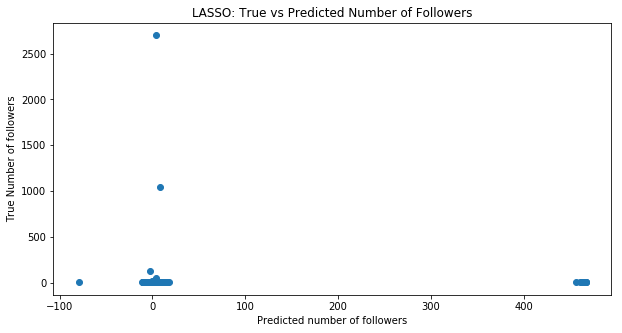

In [55]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

ax.scatter(las.predict(X_test), y_test)
ax.set_title('LASSO: True vs Predicted Number of Followers')
ax.set_ylabel('True Number of followers')
ax.set_xlabel('Predicted number of followers')

In [56]:
xgbr = xgb.XGBRegressor(max_depth=10, 
                        learning_rate=0.1, 
                        n_estimators=60, 
                        silent=True, 
                        min_child_weight=1,
                        objective='reg:linear')
xgbr.fit(X_train, y_train, eval_metric='rmse', verbose = False, eval_set = [(X_train,y_train),(X_test, y_test)],early_stopping_rounds=10)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

We can notice that our GBT model is actually overfitting but fares far better than some of the other models we ran it against. A solution to this, might be to decrease the number of trees, but there is still a lot of work to do.

In [57]:
xgbr.score(X_test, y_test)

-11.147813673648637

In [58]:
# overfitting going on (possible from a lot of trees)
# decrease depth of trees
xgbr.score(X_train, y_train)

0.6763274370298381

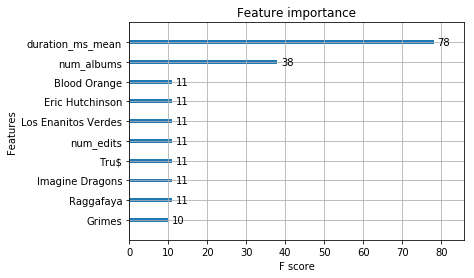

In [59]:
xgb.plot_importance(xgbr,max_num_features=10)

Given that the number of followers does seem to be a good response variable, returning to our original base model and improving upon that rather than deviating seems to be the best approach since there are too many unaccounted for predictor variables when using num_followers as our response and the noise from popular generated playlists is skewing predictions.

## Artificial Neural Network


Our artificial neural network is based on the research of the paper: **Neural Collaborative Filtering** https://arxiv.org/pdf/1708.05031.pdf. In this paper, the matrix factorization and lantent vector technique is applied to deal with the input of data and these two techniques will be used in the artificial neural network we created.

**Model Description**

We will do a little manipulation in our data to put it into a matrix: matrix shown below.
Each row of the matrix represent the user(playlist) and each column of matrix represent the item(tracks). The value of the matrix is the "interaction". We mark "1" as the interaction of user and item exist and 0 otherwise. As illustrated before, the "interaction" means that the user have the item in his/her pocket.
![Compare](image/compare.jpg)

Matrix Factorization (MF) associates each user and item with a real-valued vector of latent features. It is shown below. The latent features are presented in the right handside of the above figures as compared with the matrix. As the research of **Neural Collaborative Filtering** indicated, there are some differences between "Jaccard similarity" and the "matrix factorization": in matrix, the u4 is most similar to u1, followed by u3 and u2 while in MF, the P4 is similar to P1, followed by P2 and P3 which indicated the "ranking lost" of MF. This could be one of the source of the model limitations.
![MF](image/mf.jpg)

**Model Design**

Our neural network aimed to estimate the function to predict the y_hat(ui). The input layer includes two dataset: the "user" and "track". The second layer is the embedding layer with user latent vector and track latent vector. And we added other layers in neural network to tune our predictions. The output layer is the predicted "interaction" ('y' in dataset). The prediction score is a probability ranged from 0 to 1. The probability indicated the likelyhood of the iteraction between the playlist and track. The higher the probability, the more likely that the user will like the track.
![Neural Network Model](image/neural_network_model.jpg)

**Adjusting Model Parameter**

There are several parameters here that we need to adjust while we could not show the process of all of it for this scope of project. Hence, we apply most of the parameters tested in previous paper and show just three of them in this project: latent_dims, learning rate, epochs.

The dataset we use adjust the parameters is the data_adjust, which take the 10th piece of the original data(1000 playlists). We seperate the data into training and testing(validation) set for the ratio of 0.8 to 0.2. After adjuting the parameter, we build our final model for the optimal parameters and fit the full dataset(10,000 playlist) like we did in previous model.

**About Prediction**

The prediction of this model will not be a recommendation list but the likelihood of if the user will posisbly interact with each specific track.

In [60]:
#create the matrix for (user, track)
#input: a dataframe of (user, track, interaction)
#output: the designed matrix
def get_matrix(data, no_interaction):
    num_user = len(data['user'].unique())
    num_track = len(data['track'].unique())
    data_matrix = sp.dok_matrix((num_user, num_track), dtype=np.float32)
    for u, t in zip(data['user'], data['track']):
        data_matrix[u, t] = 1.0
    return num_user, num_track, data_matrix

**As we know, the unique tracks in all the 10,000 playlists will be huge. Hence, if we use all the tracks that exist and donnot exist in each individual user, the portion of "not existing" tracks will be much bigger than that of "existing tracks". Therefore, if we do so, our prediction will always prediction the track to "not exist" in the playlist and we will get a high score of 0.99999999. It doesn't make sense though.**

**So the following functions is to randomly get our training data to make it include 0.5-0.5 true and false response portion in both our training and test set so that our decision boundry will be 0.5 as default in neural network.**

In [61]:
#get the random features
#input: the data matrix
#output: the desighed user, track input and response variable
def get_features(data_matrix):
    num_user, num_track = data_matrix.shape
    user_data, track_data, y_data = [],[],[]
    
    for (u, i) in data_matrix.keys():
        user_data.append(u)
        track_data.append(i)
        y_data.append(1)
        
        for t in range(no_interaction):
            j = np.random.randint(num_track)
            while (u,j) in data_matrix:
                j = np.random.randint(num_user)
            user_data.append(u)
            track_data.append(j)
            y_data.append(0)
                
    return user_data, track_data, y_data

In [62]:
#build the model
def build_model(num_user, num_track, latent_dim):
    user_train = Input(shape=(1,), dtype='int32', name = 'user_train')
    track_train = Input(shape=(1,), dtype='int32', name = 'track_train')

    MF_Embedding_user = Embedding(input_dim = num_user, output_dim = latent_dim, embeddings_initializer='uniform', embeddings_regularizer = l2([0,0][0]), input_length=1)
    MF_Embedding_track = Embedding(input_dim = num_track, output_dim = latent_dim, embeddings_initializer='uniform', embeddings_regularizer = l2([0,0][0]), input_length=1)   
    
    user_latent = Flatten()(MF_Embedding_user(user_train))
    track_latent = Flatten()(MF_Embedding_track(track_train))

    predictor = add([user_latent, track_latent])
    prediction = Dense(1, activation="sigmoid", name="prediction", kernel_initializer="lecun_uniform")(predictor)
    NNmodel = Model(inputs=[user_train, track_train], outputs=prediction)
    return NNmodel

**Parameter Selection**

In [63]:
#define the function to make plot for selection parameters
def make_plot(x, y_train, y_test, name):
    fig, ax = plt.subplots(1,1, figsize=(8, 5))
    ax.plot(x, y_train, label='train')
    ax.plot(x, y_test, label='test')
    ax.set_xlabel(name)
    ax.set_ylabel('scores')
    ax.set_title('{} Selection'.format(name))
    ax.legend()
    return

In [64]:
#get matrix
no_interaction = 1
num_user, num_track, matrix = get_matrix(data_adjust, no_interaction)
user, track, y = get_features(matrix)
data_nn = pd.DataFrame(user, columns=['user'])
data_nn['track'] = track
data_nn['y'] = y

#get train and test data
data_copy = data_nn.copy()
data_test = pd.DataFrame(columns=['user', 'track', 'y'])
for n in range(n_adjust*900, n_adjust*1000):
    data_hide = data_copy[data_copy.user == n].iloc[0:2]
    data_test = data_test.append(data_hide)
    
data_train = data_copy.drop(data_test.index)

user_train = data_train.user
track_train = data_train.track
y_train = data_train.y

user_test = data_test.user
track_test = data_test.track
y_test = data_test.y

In [65]:
#define parameter range
latent_dims = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 100]
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
epochss = [3, 20]

**1. Latent Dimension Selection**

In [66]:
learning_rate = learning_rates[1]
epochs = epochss[0]
latent_dim_list, train_score_list, test_score_list = [], [], []
for latent_dim in latent_dims:
    NNmodel = build_model(num_user, num_track, latent_dim)
    NNmodel.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    NNmodel.fit([np.array(user_train), np.array(track_train)], np.array(y_train), epochs=epochs, batch_size=200, validation_split = .2)
    NN_train_score = NNmodel.evaluate([np.array(user_train), np.array(track_train)], np.array(y_train))[1]
    NN_test_score = NNmodel.evaluate([np.array(user_test), np.array(track_test)], np.array(y_test))[1]
    latent_dim_list.append(latent_dim)
    train_score_list.append(NN_train_score)
    test_score_list.append(NN_test_score)

Train on 104548 samples, validate on 26138 samples
Epoch 1/3
104548/104548 [==============================] - 1s 12us/step - loss: 0.6927 - acc: 0.5136 - val_loss: 0.6915 - val_acc: 0.5341
Epoch 2/3
104548/104548 [==============================] - 1s 5us/step - loss: 0.6877 - acc: 0.5836 - val_loss: 0.6880 - val_acc: 0.5595
Epoch 3/3
200/200 [==============================] - 0s 87us/step
Train on 104548 samples, validate on 26138 samples
Epoch 1/3
104548/104548 [==============================] - 1s 9us/step - loss: 0.6922 - acc: 0.5156 - val_loss: 0.6893 - val_acc: 0.5446
Epoch 2/3
104548/104548 [==============================] - 1s 7us/step - loss: 0.6810 - acc: 0.6073 - val_loss: 0.6825 - val_acc: 0.5719
Epoch 3/3
200/200 [==============================] - 0s 22us/step
Train on 104548 samples, validate on 26138 samples
Epoch 1/3
104548/104548 [==============================] - 1s 12us/step - loss: 0.6923 - acc: 0.5174 - val_loss: 0.6901 - val_acc: 0.5463
Epoch 2/3
104548/104548 [===

104548/104548 [==============================] - 23s 216us/step - loss: 0.6870 - acc: 0.5375 - val_loss: 0.6718 - val_acc: 0.5881
Epoch 2/3
104548/104548 [==============================] - 17s 164us/step - loss: 0.6236 - acc: 0.6732 - val_loss: 0.6751 - val_acc: 0.5923
Epoch 3/3
200/200 [==============================] - 0s 31us/step
Train on 104548 samples, validate on 26138 samples
Epoch 1/3
104548/104548 [==============================] - 21s 198us/step - loss: 0.6870 - acc: 0.5355 - val_loss: 0.6713 - val_acc: 0.5847
Epoch 2/3
104548/104548 [==============================] - 19s 183us/step - loss: 0.6220 - acc: 0.6738 - val_loss: 0.6780 - val_acc: 0.5909
Epoch 3/3
200/200 [==============================] - 0s 55us/step
Train on 104548 samples, validate on 26138 samples
Epoch 1/3
104548/104548 [==============================] - 24s 232us/step - loss: 0.6867 - acc: 0.5357 - val_loss: 0.6690 - val_acc: 0.5925
Epoch 2/3
104548/104548 [==============================] - 23s 222us/step - 

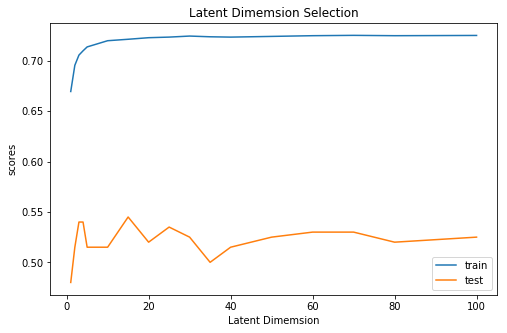

In [67]:
make_plot(latent_dim_list, train_score_list, test_score_list, 'Latent Dimemsion')

It seems like the dimension doesn't affect the result since the plot is very random. And according to previous paper, we select the dimension of 10.

**2. Learning Rage Selection**

In [68]:
latent_dim = 10
epochs = epochss[0]
learning_rate_list, train_score_list, test_score_list = [], [], []
for learning_rate in learning_rates:
    NNmodel = build_model(num_user, num_track, latent_dim)
    NNmodel.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    NNmodel.fit([np.array(user_train), np.array(track_train)], np.array(y_train), epochs=epochs, batch_size=200, validation_split = .2)
    NN_train_score = NNmodel.evaluate([np.array(user_train), np.array(track_train)], np.array(y_train))[1]
    NN_test_score = NNmodel.evaluate([np.array(user_test), np.array(track_test)], np.array(y_test))[1]
    learning_rate_list.append(learning_rate)
    train_score_list.append(NN_train_score)
    test_score_list.append(NN_test_score)

Train on 104548 samples, validate on 26138 samples
Epoch 1/3
104548/104548 [==============================] - 3s 27us/step - loss: 0.6930 - acc: 0.5051 - val_loss: 0.6923 - val_acc: 0.5184
Epoch 2/3
104548/104548 [==============================] - 2s 20us/step - loss: 0.6906 - acc: 0.5512 - val_loss: 0.6910 - val_acc: 0.5389
Epoch 3/3
200/200 [==============================] - 0s 24us/step
Train on 104548 samples, validate on 26138 samples
Epoch 1/3
104548/104548 [==============================] - 3s 30us/step - loss: 0.6908 - acc: 0.5279 - val_loss: 0.6855 - val_acc: 0.5675
Epoch 2/3
104548/104548 [==============================] - 2s 22us/step - loss: 0.6652 - acc: 0.6525 - val_loss: 0.6684 - val_acc: 0.5883
Epoch 3/3
200/200 [==============================] - 0s 26us/step
Train on 104548 samples, validate on 26138 samples
Epoch 1/3
104548/104548 [==============================] - 3s 29us/step - loss: 0.6879 - acc: 0.5366 - val_loss: 0.6733 - val_acc: 0.5858
Epoch 2/3
104548/104548 [

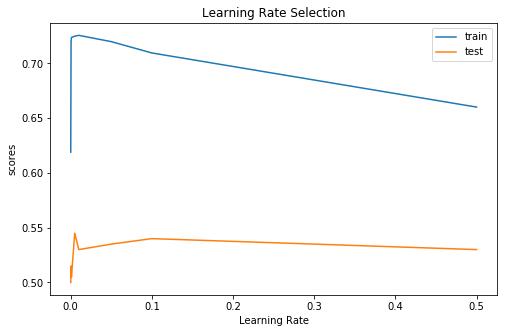

In [69]:
make_plot(learning_rate_list, train_score_list, test_score_list, 'Learning Rate')

learning rate of 0.001 looks the best

**Epochs Selection**

In [70]:
latent_dim = 10
learning_rate = 0.001
epochs = 20
NNmodel = build_model(num_user, num_track, latent_dim)
NNmodel.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
NNmodel.fit([np.array(user_train), np.array(track_train)], np.array(y_train), epochs=epochs, batch_size=200, validation_split = .2)

Train on 104548 samples, validate on 26138 samples
Epoch 1/20
104548/104548 [==============================] - 4s 40us/step - loss: 0.6883 - acc: 0.5331 - val_loss: 0.6731 - val_acc: 0.5827
Epoch 2/20
104548/104548 [==============================] - 2s 23us/step - loss: 0.6277 - acc: 0.6727 - val_loss: 0.6668 - val_acc: 0.5945
Epoch 3/20
104548/104548 [==============================] - 2s 21us/step - loss: 0.5681 - acc: 0.7133 - val_loss: 0.7197 - val_acc: 0.5905
Epoch 4/20
104548/104548 [==============================] - 2s 21us/step - loss: 0.5424 - acc: 0.7255 - val_loss: 0.7747 - val_acc: 0.5895
Epoch 5/20
104548/104548 [==============================] - 2s 21us/step - loss: 0.5296 - acc: 0.7326 - val_loss: 0.8208 - val_acc: 0.5890
Epoch 6/20
104548/104548 [==============================] - 2s 22us/step - loss: 0.5219 - acc: 0.7354 - val_loss: 0.8600 - val_acc: 0.5878
Epoch 7/20
104548/104548 [==============================] - 2s 22us/step - loss: 0.5166 - acc: 0.7384 - val_loss: 0

The result does not improve much around epochs 5 and hence we choose epochs 5.

**Create The Final Neural Network Model**

In [71]:
#Use the optimal parameter and train the final model
latent_dim = 10
learning_rate = 0.001
epochs = 5

In [72]:
#get matrix of the full dataset
no_interaction = 1
num_user, num_track, matrix = get_matrix(data_full, no_interaction)
user, track, y = get_features(matrix)
data_nn = pd.DataFrame(user, columns=['user'])
data_nn['track'] = track
data_nn['y'] = y

#get train and test data
data_copy = data_nn.copy()
data_test = pd.DataFrame(columns=['user', 'track', 'y'])
for n in range(n_playlist*900, n_playlist*1000):
    data_hide = data_copy[data_copy.user == n].iloc[0:2]
    data_test = data_test.append(data_hide)
    
data_train = data_copy.drop(data_test.index)

user_train = data_train.user
track_train = data_train.track
y_train = data_train.y

user_test = data_test.user
track_test = data_test.track
y_test = data_test.y

In [73]:
#Build the final model
NNmodel = build_model(num_user, num_track, latent_dim)
NNmodel.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
print(NNmodel.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_train (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
track_train (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_53 (Embedding)        (None, 1, 10)        100000      user_train[0][0]                 
__________________________________________________________________________________________________
embedding_54 (Embedding)        (None, 1, 10)        1329200     track_train[0][0]                
__________________________________________________________________________________________________
flatten_53

In [74]:
#Fit the model
NNmodel.fit([np.array(user_train), np.array(track_train)], np.array(y_train), epochs=epochs, batch_size=200, validation_split = .2)
NN_train_score = NNmodel.evaluate([np.array(user_train), np.array(track_train)], np.array(y_train))[1]
NN_test_score = NNmodel.evaluate([np.array(user_test), np.array(track_test)], np.array(y_test))[1]

Train on 1042625 samples, validate on 260657 samples
Epoch 1/5
1042625/1042625 [==============================] - 90s 86us/step - loss: 0.5454 - acc: 0.7226 - val_loss: 0.4986 - val_acc: 0.7673
Epoch 2/5
1042625/1042625 [==============================] - 89s 85us/step - loss: 0.4562 - acc: 0.7914 - val_loss: 0.5134 - val_acc: 0.7667
Epoch 3/5
1042625/1042625 [==============================] - 92s 88us/step - loss: 0.4398 - acc: 0.8005 - val_loss: 0.5287 - val_acc: 0.7653
Epoch 4/5
1042625/1042625 [==============================] - 88s 85us/step - loss: 0.4311 - acc: 0.8047 - val_loss: 0.5379 - val_acc: 0.7649
Epoch 5/5
2000/2000 [==============================] - 0s 21us/step


In [75]:
print('The NN train score is {}'.format(round(NN_train_score, 2)))
print('The NN test score is {}'.format(round(NN_test_score, 2)))

The NN train score is 0.81
The NN test score is 0.75


In [76]:
min_train_score = 1 - np.mean(y_train)
min_test_score = 1 - np.mean(y_test)
print('The minimum train score is {}'.format(round(min_train_score, 2)))
print('The minimum test score is {}'.format(round(min_test_score, 2)))

The minimum train score is 0.5
The minimum test score is 0.5


From the result we can see that our model works much better than the minimum score which is 0.5 - 0.5.

The test score means that in test set, we successfully predict a large portion of the test tracks for each user in to the right category (with interaction or without interaction. The result means that, given a user and a track, we can define if the user and the track has possible interactions. It is logically very useful in generating a recommendation list: we can take the top 100 tracks with highest probability of interaction from our full unique tracks dataset as the recommendation list.

In the follwoing section of combined model, we will apply this idea to generate our final recommendation list.

# Combined Model: Generating Recommendation List

As we did before, we will hide one track in each playlist(user) and generate a recommendation list, see if this recommendation list contain that hidden track. However, due to our limitation of training data size and the very large tracks in the the music bank, we don't expect that for a large percent of time, we can successfully find out that exact one hidden track. In real world, the user preference can be much broader than just one "hidden" track.

We choose to combine the baseline model and Neural Network model together to generate the list. First, we will extract our previous recommendation list (including the not overlap tracks of top 5 similar playlists in baseline model). Instead of randomly select 100 of them as recommendation, we apply the trained Artifical Neural Network to rank the possible interactions and select the top 100 tracks with the highest interaction score and use them as our final recommendation list.

As far as our prediction score increase (higher than what we get in baseline model), our neural network works.

In [77]:
recom_list_combine = recommendation_list.copy()

In [78]:
recommendation_scores = np.zeros(len(track_hide))
for x in range(len(track_hide)):
    track_full_list = list(set(recom_list_combine[x]))
    existing_track = data_train[data_train['user'] == x].track
    hidden_track = list(track_test)[x*2]
    predict_track = list(Counter(track_full_list)-Counter(existing_track))
    predict_user = np.zeros(len(predict_track))+x
    
    s = NNmodel.predict([np.array(x).reshape(-1,1), np.array(hidden_track).reshape(-1,1)])
    #print('score is {}'.format(s))
    
    predictions = np.transpose(NNmodel.predict([predict_user, np.array(predict_track)]))[0]
    index = np.argsort(predictions)[-no_recommendation:]

    recommendation_list_ann = np.array(predict_track)[index]
    
    if hidden_track in recommendation_list_ann:
        recommendation_scores[x] = 1
        
total_score = np.average(recommendation_scores)

In [79]:
print('For {} percent of time, we successfully include the hidden track'.format(round(total_score*100)))

For 26.0 percent of time, we successfully include the hidden track


Just as what we have expected, even thouth the predction accuracy of neural network is very high, the probability that the recommendation list we generate that will include the hidden track is very low because:

 - The hidden track is not the exact indicator of "user preference" because the user may have higher probability to like the other traks that does not neccessarily to be the hidden track! Hence the real "user preference" for the not hidden track in other playlist will be higher than the actual "hidden track" that we hided before. But in the scope of this project, we are not able to find out the true user preference and hence, we can just use the "hidden track" as a possible indicator.
 
Therefore, even though our score is not very high, it did improve a lot comparing to our baseline model, which is basically in random basesa. This is consistant with our high neural network prediction results.

In [80]:
#calculate the running time of whole script
end = timer()
print(end-start)

2526.3742469080007
